In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pickle
from utils.vmf_batch import vMF
from datetime import datetime
from importlib import reload
import os

from models import SeqEncoder, SeqDecoder, Seq2Seq_VAE, PoolingClassifier, init_weights
from itertools import product
from training_utils import  train, evaluate, scale


## plotting ###

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
SEED = 17
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MASKING_ELEMENT =0

In [3]:
folder = '5_populations'
with open('./data/toy_data/%s/iterator/scaling_val_iterator.pkl'%folder, 'rb') as f:
    val_iterator = pickle.load(f)

with open('./data/toy_data/%s/iterator/scaling_train_iterator.pkl'%folder, 'rb') as f:
    train_iterator = pickle.load(f)
    
N_train = len(train_iterator.sampler.indices)
N_val = len(val_iterator.sampler.indices)
n_walks = train_iterator.dataset.n_walks

In [4]:

def calculate_loss(x, reconstructed_x, ignore_el=MASKING_ELEMENT):
    # reconstruction loss
    # x = [trg len, batch size * n walks, output dim]

    seq_len , bs, output_dim = x.shape
    mask = x[:,:,0] != ignore_el
    RCL = 0
    for d in range(output_dim):
        RCL += mse_loss(reconstructed_x[:,:,d][mask], x[:,:,d][mask])
    RCL /= output_dim
    
    return RCL


In [6]:
torch.cuda.empty_cache()

In [5]:
# parameter
INPUT_DIM = 3   
lr = 1e-2                           # learning rate
NUM_LAYERS = 2
NUM_CLASSES = 5#3
N_EPOCHS = 150
MASKING_ELEMENT = 0

In [ ]:
np.random.seed(SEED)
torch.manual_seed(SEED)

emb_dim = 32
latent_dim = 32
dpout = .1
kappa = 500
pool = 'max'
    
### train the model(s)
for frac in [1. , 0.]:
    for k in range(1):
        start = datetime.now()
        # model
        enc = SeqEncoder(INPUT_DIM, emb_dim, emb_dim, NUM_LAYERS, dpout)
        dec = SeqDecoder(INPUT_DIM, emb_dim, emb_dim, NUM_LAYERS, dpout)
        dist = vMF(latent_dim, kappa=kappa)
        model = Seq2Seq_VAE(enc, dec, dist, device).to(device)
        classifier = PoolingClassifier(latent_dim, NUM_CLASSES, n_walks,dpout,pooling=pool).to(device)
        
        # losses
        cross_entropy_loss = nn.CrossEntropyLoss(reduction='sum')
        mse_loss = nn.MSELoss(reduction='sum')
        
        suffix = 'emb%i_hid%i_lat%i_dp%.1f_k%i_%s'%(emb_dim,emb_dim,latent_dim,dpout,kappa,pool)
        suffix += '_frac%.1f'%frac
        suffix += '_scaled'
        suffix += '_sum'
        save_path_model = './models/%s/%s_run%i_best.pt'%(folder,suffix,(k+1))
        save_path_losses = './models/%s/losses_%s_%i.npy'%(folder, suffix, (k+1))
        
        if os.path.exists(save_path_model):
            
            # load model and train further
            state_dict = torch.load(save_path_model)
            model.load_state_dict(state_dict['model_state_dict'])
            classifier.load_state_dict(state_dict['classifier_state_dict'])
            
            optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()))
            optimizer.load_state_dict(state_dict['optimizer_state_dict'])
            # half the learning rate to be consistent with the other training
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2
            
            losses = np.load(save_path_losses)
            best_test_loss = losses[state_dict['epoch'],2]
            training = list(losses[:,:2])
            validation = list(losses[:,2:])
            last_epoch = losses.shape[0]
            
        else:
            # initialize model
            model.apply(init_weights)
            classifier.apply(init_weights)


            #optimizer
            optimizer = optim.Adam(list(model.parameters()) + list(classifier.parameters()), lr=lr)

            best_test_loss = np.infty
            training = []
            validation = []
       
            last_epoch = 0
            
        for e in range(last_epoch, N_EPOCHS):

            train_loss, train_class_loss = train(model, classifier, train_iterator, optimizer, 
                                               calculate_loss,cross_entropy_loss, 
                                                 clip=1,norm_p=None, class_fraction=frac)
            val_loss, val_class_loss = evaluate(model,classifier, val_iterator,
                                                 calculate_loss, cross_entropy_loss, norm_p=None)


            train_loss /= N_train
            train_class_loss /= N_train
            val_loss /= N_val
            val_class_loss /=N_val

            training += [[train_loss, train_class_loss]]
            validation += [[val_loss, val_class_loss]]
            print(f'Epoch {e}, Train Loss: {train_loss:.9f}, Test Loss: {val_loss:.9f}')


            if e % 50 == 0 and e > 0 :
                optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr']/2

            if best_test_loss > val_loss:
                best_test_loss = val_loss
                end = datetime.now()
                torch.save({'epoch': e,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'classifier_state_dict': classifier.state_dict()
                               }, save_path_model)
                # save training and validation loss
                validation_ = np.array(validation)
                training_ = np.array(training)
                losses = np.concatenate((training_, validation_), axis=1)
                # losses [:,0] = training loss, [:,1] = training classification loss
                # [:,2] = validation loss, [:,3] = validation classification loss
                with open(save_path_losses, 'wb') as f:
                    np.save(f,losses)

        validation_ = np.array(validation)
        training_ = np.array(training)
        losses = np.concatenate((training_, validation_), axis=1)
        # losses [:,0] = training loss, [:,1] = training classification loss
        # [:,2] = validation loss, [:,3] = validation classification loss
        with open(save_path_losses, 'wb') as f:
            np.save(f,losses)
        end = datetime.now()
        print('Time to fit model %i : '%(k+1), end-start)
    torch.cuda.empty_cache()

KLD: 45.709938049316406
Epoch 0, Train Loss: 3827.649593750, Test Loss: 16823.017500000
Epoch 1, Train Loss: 2891.111500000, Test Loss: 20616.311000000
Epoch 2, Train Loss: 2295.264265625, Test Loss: 27830.733000000
Epoch 3, Train Loss: 1985.287640625, Test Loss: 28018.933000000
Epoch 4, Train Loss: 1868.439203125, Test Loss: 26623.088000000
Epoch 5, Train Loss: 1808.230531250, Test Loss: 15454.372500000
Epoch 6, Train Loss: 1757.370515625, Test Loss: 18782.912000000
Epoch 7, Train Loss: 1710.964843750, Test Loss: 17382.072000000
Epoch 8, Train Loss: 1696.632718750, Test Loss: 17250.768000000
Epoch 9, Train Loss: 1657.499859375, Test Loss: 15459.180000000
Epoch 10, Train Loss: 1650.165625000, Test Loss: 13742.372000000
Epoch 11, Train Loss: 1629.673281250, Test Loss: 18179.383000000
Epoch 12, Train Loss: 1612.713671875, Test Loss: 16148.770500000
Epoch 13, Train Loss: 1563.746187500, Test Loss: 16194.820500000
Epoch 14, Train Loss: 1552.856812500, Test Loss: 10964.830000000
Epoch 15, T

Epoch 129, Train Loss: 381.635847656, Test Loss: 1563.037312500
Epoch 130, Train Loss: 382.032675781, Test Loss: 1539.096500000
Epoch 131, Train Loss: 379.192421875, Test Loss: 1553.957750000
Epoch 132, Train Loss: 377.112667969, Test Loss: 1556.923687500
Epoch 135, Train Loss: 375.436984375, Test Loss: 1490.374687500
Epoch 136, Train Loss: 372.017996094, Test Loss: 1520.593562500
Epoch 137, Train Loss: 368.706632813, Test Loss: 1574.937125000
Epoch 138, Train Loss: 368.380988281, Test Loss: 1554.281687500
Epoch 139, Train Loss: 371.378382812, Test Loss: 1526.620500000
Epoch 140, Train Loss: 365.499691406, Test Loss: 1510.476687500
Epoch 141, Train Loss: 367.222371094, Test Loss: 1495.295875000
Epoch 142, Train Loss: 362.685058594, Test Loss: 1493.099000000
Epoch 143, Train Loss: 359.699132813, Test Loss: 1503.631125000
Epoch 144, Train Loss: 359.760210938, Test Loss: 1457.417625000
Epoch 145, Train Loss: 359.322304687, Test Loss: 1469.909687500
Epoch 146, Train Loss: 355.793535156, Te

In [3]:
with open('./models/5_populations/losses_emb32_hid32_lat32_dp0.1_k500_max_frac0.0_scaled_sum_1.npy', 'rb') as f:
    l = np.load(f)

Text(0, 0.5, 'Rec loss')

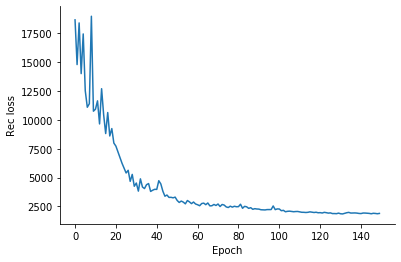

In [6]:
plt.plot(l[:,2]- l[:,3])
sns.despine()
plt.xlabel('Epoch')
plt.ylabel('Rec loss')